In [61]:
%env MUJOCO_GL=egl

from collections import namedtuple
from metaworld.envs import ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE

env_name = "drawer-open-v2-goal-observable"
env_cls = ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE[env_name]
e  = ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE[env_name](render_mode="rgb_array")
e.width = 256
e.height = 256
e.camera_name = "top_cap2"
# e.mujoco_renderer.width = 256
# e.mujoco_renderer.height = 256
e._freeze_rand_vec = False
e.spec = namedtuple('spec', ['id', 'max_episode_steps'])
e.spec.id = env_name
e.spec.max_episode_steps = 500
e.model.vis.global_.offwidth = 256
e.model.vis.global_.offheight = 256
e.reset()


env: MUJOCO_GL=egl


(array([0.00615235, 0.60018983, 0.19430118, 1.        , 0.0287359 ,
        0.72999998, 0.09      , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00615235, 0.60018983,
        0.19430118, 1.        , 0.0287359 , 0.72999998, 0.09      ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.0287359 , 0.53999998, 0.09      ]),
 {})

(256, 256, 3)


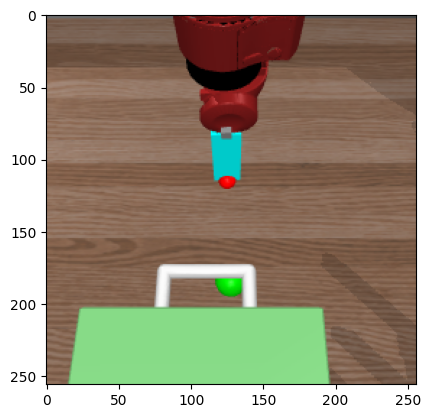

In [62]:
import matplotlib.pyplot as plt
import numpy as np

image = e.render()
print(image.shape)
plt.imshow(image)


In [63]:
import pickle
with open("/home/yicheng/Downloads/drawer-open-v2-goal-observable.pickle", "rb") as f:
    episodes = pickle.load(f)


In [64]:
len(episodes)
print(episodes[0].keys())

for k in episodes[0]:
    if k == "env_infos":
        pass
        # print(k, episodes[0]["env_infos"])
    else:
        print(k, episodes[0][k].shape)


dict_keys(['observations', 'actions', 'rewards', 'env_infos', 'images'])
observations (500, 39)
actions (500, 4)
rewards (500,)
images (500, 256, 256, 3)


In [53]:
import haiku as hk
import jax
import jax.numpy as jnp
import tensorflow as tf

## State Experiment


In [21]:
import optax

def create_dataset(episodes):
    obs = []
    actions = []
    for episode in episodes:
        obs.append(episode["observations"])
        actions.append(episode["actions"])
    obs = np.concatenate(obs)
    actions = np.concatenate(actions)
    return tf.data.Dataset.from_tensor_slices((obs, actions))

def _forward_fn(obs):
    return hk.Sequential(
        [
            hk.LayerNorm(axis=-1, create_scale=True, create_offset=True),
            jnp.tanh,
            hk.nets.MLP(output_sizes=[256, 256, 4], activate_final=False),
        ]
    )(obs)


dataset_iterator = (
    create_dataset(episodes)
    .shuffle(int(1e6), reshuffle_each_iteration=True)
    .repeat()
    .batch(256)
    .repeat()
    .as_numpy_iterator()
)

model = hk.without_apply_rng(hk.transform(_forward_fn))
params = model.init(jax.random.PRNGKey(42), jnp.zeros((1, 39)))


optimizer = optax.adam(3e-4)
opt_state = optimizer.init(params)


def loss_fn(params, batch):
    obs, act = batch
    predicted_actions = model.apply(params, obs)
    return jnp.mean(jnp.square(predicted_actions - act))


@jax.jit
def train_step(params, opt_state, batch):
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


for step in range(50000):
    params, opt_state, loss = train_step(params, opt_state, next(dataset_iterator))
    if step % 1000 == 0:
        print(step, "loss", jax.device_get(loss))

0 loss 0.919367
1000 loss 0.024111286
2000 loss 0.026884735
3000 loss 0.016332202
4000 loss 0.0127630215
5000 loss 0.0066728746
6000 loss 0.004284828
7000 loss 0.005852307
8000 loss 0.010149155
9000 loss 0.0076074833
10000 loss 0.005950979
11000 loss 0.004682432
12000 loss 0.0017558809
13000 loss 0.005770659
14000 loss 0.0037083658
15000 loss 0.0032333625
16000 loss 0.0042039226
17000 loss 0.0065583754
18000 loss 0.003182693
19000 loss 0.004297521
20000 loss 0.0024222634
21000 loss 0.00086279435
22000 loss 0.0031437844
23000 loss 0.011774261
24000 loss 0.0014128784
25000 loss 0.0023462162
26000 loss 0.003506763
27000 loss 0.0022512428
28000 loss 0.001955809
29000 loss 0.006957469
30000 loss 0.005825908
31000 loss 0.009324353
32000 loss 0.012891131
33000 loss 0.0067153424
34000 loss 0.0020942362
35000 loss 0.0057964292
36000 loss 0.0066289594
37000 loss 0.007444975
38000 loss 0.0032958582
39000 loss 0.007478228
40000 loss 0.0037239227
41000 loss 0.0013998935
42000 loss 0.001965611
43000

In [23]:
@jax.jit
def policy(params, obs):
    return model.apply(params, obs)

for _ in range(10):
    episode_return = 0
    obs, info = e.reset()
    while True:
        action = policy(params, obs[None, ...])
        obs, reward, terminated, truncated, info = e.step(np.asarray(action[0]))
        if terminated or truncated:
            print(info["success"], )
            break

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


## Pixel Experiment


In [54]:
from safetensors.flax import load_file
from jam.haiku import r3m
from jam import imagenet_util

import optax

resnet_size = 18
model_name ="r3m-18"

def r3m_forward(inputs, is_training=True):
    model = r3m.R3M(resnet_size)
    return model(inputs, is_training)

r3m_model = hk.without_apply_rng(hk.transform_with_state(r3m_forward))

state_dict = load_file(f"/home/yicheng/projects/rl_workspace/jam/data/models/r3m/{model_name}/torch_model.safetensors")
r3m_params, r3m_state = r3m.load_from_torch_checkpoint(state_dict)

# r3m_model.apply(r3m_params, r3m_state, jnp.zeros((1, 256, 256, 3)), is_training=False)[0].shape

@jax.jit
def preprocess_image(params, state, images):
    assert images.dtype == jnp.uint8
    images = (images.astype(jnp.float32) - np.asarray(imagenet_util.IMAGENET_MEAN_RGB)) / np.asarray(imagenet_util.IMAGENET_STDDEV_RGB)
    return r3m_model.apply(params, state, images, is_training=False)[0]

def create_dataset(episodes):
    obs = []
    actions = []
    for episode in episodes:
        images = episode["images"]
        embeddings = jax.device_get(preprocess_image(r3m_params, r3m_state, images))
        obs.append(embeddings)
        actions.append(episode["actions"])
    obs = np.concatenate(obs)
    actions = np.concatenate(actions)
    return tf.data.Dataset.from_tensor_slices((obs, actions))

dataset = create_dataset(episodes)


In [66]:
def _forward_fn(obs):
    return hk.Sequential(
        [
            hk.LayerNorm(axis=-1, create_scale=True, create_offset=True),
            jnp.tanh,
            hk.nets.MLP(output_sizes=[256, 256, 4], activate_final=False),
        ]
    )(obs)


model = hk.without_apply_rng(hk.transform(_forward_fn))
params = model.init(jax.random.PRNGKey(42), jnp.zeros((1, 512)))


optimizer = optax.adam(3e-4)
opt_state = optimizer.init(params)


def loss_fn(params, batch):
    obs, act = batch
    predicted_actions = model.apply(params, obs)
    return jnp.mean(jnp.square(predicted_actions - act))


@jax.jit
def train_step(params, opt_state, batch):
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

dataset_iterator = (
    dataset
    .shuffle(int(1e6), reshuffle_each_iteration=True)
    .repeat()
    .batch(256)
    .repeat()
    .as_numpy_iterator()
)
for step in range(10000):
    params, opt_state, loss = train_step(params, opt_state, next(dataset_iterator))
    if step % 5000 == 0:
        print(step, "loss", jax.device_get(loss))

0 loss 0.8798146
5000 loss 0.0021174266


In [67]:
@jax.jit
def policy(params, obs):
    return model.apply(params, obs)

for _ in range(10):
    episode_return = 0
    obs, info = e.reset()
    image = e.render()

    while True:
        action = policy(params, preprocess_image(r3m_params, r3m_state, image[None, ...]))
        obs, reward, terminated, truncated, info = e.step(np.asarray(action[0]))
        image = e.render()
        if terminated or truncated:
            print(info["success"], )
            break

1.0
1.0
1.0
1.0
1.0
1.0


KeyboardInterrupt: 